In [9]:
import logging

%load_ext autoreload
%autoreload 2

import src.utils
from src.experiment import Experiment

import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning of Quantum Chaos

In [137]:
raw_path = '../data/raw'
labels_mapping = utils.get_labels_mapping(utils.listdir(raw_path))

splitting_info = {
    'chaotic': ['sinai03'],
    'regular': ['sinai0']
}

config = {
    'test_size': 0.33,
    'labels_mapping': labels_mapping,
    'splitting_info': splitting_info,
    
    'piece_width': 60,
    'piece_height': 60,
    'num_pieces': 100,
    'downsampling_factor': 3
    
}

exper = Experiment(config=config, logging_level=logging.INFO)
print(exper)

Initialization
======= - INFO - experiment - 2018-07-16 18:38:12,361
DONE with Initialization. `expN` is 1 - INFO - experiment - 2018-07-16 18:38:12,363


Experiment #1
--------------
Dataset: sinai03 vs. sinai0 

Portion of dataset for testing: 0.33
Splitting info:
{'chaotic': ['sinai03'], 'regular': ['sinai0']}

Labels mapping:
{'quarterL001': 0, 'test': 1, 'sinai01': 2, 'test1': 3, 'quarterL0': 4, 'circle_orange': 5, 'sinai03': 6, 'sinai02': 7, 'test2': 8, 'bunimovich': 9, 'sinai0': 10}
Splitting mapping:
{'chaotic': 0, 'regular': 1}


In [138]:
exper.prepare_images()

Prepare images
======= - INFO - experiment - 2018-07-16 18:38:12,861
> FAILED: data/raw/sinai03/original/psi2_n=197_En=2562.5042.png - INFO - experiment - 2018-07-16 18:38:13,133
DONE with sinai03 - INFO - experiment - 2018-07-16 18:38:13,758
DONE with sinai0 - INFO - experiment - 2018-07-16 18:38:15,226


In [139]:
exper.slicing()

Slicing
======= - INFO - experiment - 2018-07-16 18:38:16,320
60 x 60 --> 20 x 20 - INFO - experiment - 2018-07-16 18:38:16,325
DONE with sinai03 - INFO - experiment - 2018-07-16 18:38:18,412
DONE with sinai0 - INFO - experiment - 2018-07-16 18:38:20,538


In [140]:
exper.dumping()

Dumping
======= - INFO - experiment - 2018-07-16 18:38:20,591
DONE with sinai03 - INFO - experiment - 2018-07-16 18:38:21,128
DONE with sinai0 - INFO - experiment - 2018-07-16 18:38:21,775


In [141]:
exper.split_test_train()

Split Test/Train
======= - INFO - experiment - 2018-07-16 18:38:23,357
Sizes: 1340 660 - INFO - experiment - 2018-07-16 18:38:23,377
DONE with train-images.pkl - INFO - experiment - 2018-07-16 18:38:23,391
DONE with test-images.pkl - INFO - experiment - 2018-07-16 18:38:23,398
DONE with train-labels.pkl - INFO - experiment - 2018-07-16 18:38:23,402
DONE with test-labels.pkl - INFO - experiment - 2018-07-16 18:38:23,410
DONE with train-energy-levels.pkl - INFO - experiment - 2018-07-16 18:38:23,414
DONE with test-energy-levels.pkl - INFO - experiment - 2018-07-16 18:38:23,419


# (5) Attaching PyTorch

In [142]:
from PIL import Image
import pickle
import tqdm
import os

import torch
import torchvision
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2

from src.billiard import Billiard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
expN = 1

batch_size = 30
test_batch_size = 10
# selected_energy_levels = [197]
selected_energy_levels = None

test_loader, train_loader = get_test_train_loaders(expN, batch_size, test_batch_size, selected_energy_levels)
print(train_loader.dataset)
print(test_loader.dataset)
print()

expInfo, expName = exp_info(expN)
print(expInfo)

Processing... - INFO - billiard - 2018-07-16 18:38:28,686
Done! - INFO - billiard - 2018-07-16 18:38:28,702
Processing... - INFO - billiard - 2018-07-16 18:38:28,719
Done! - INFO - billiard - 2018-07-16 18:38:28,759


Dataset Billiard
    Number of datapoints: 1340
    Split: train
    Root Location: data/experiments/1
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset Billiard
    Number of datapoints: 660
    Split: test
    Root Location: data/experiments/1
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

Experiment #1
--------------
Dataset: sinai03 vs. sinai0 

Portion of dataset for testing: 0.33
Splitting info:
{'chaotic': ['sinai03'], 'regular': ['sinai0']}

Labels mapping:
{'quarterL001': 0, 'test': 1, 'sinai01': 2, 'test1': 3, 'quarterL0': 4, 'circle_orange': 5, 'sinai03': 6, 'sinai02': 7, 'test2': 8, 'bunimovich': 9, 'sinai0': 10}
Splitting mapping:
{'chaotic': 0, 'regular': 1}


tensor([ 0,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,
         1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  1,  1,  1,
         1,  0])


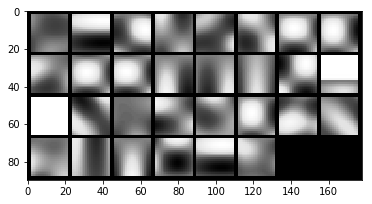

In [145]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy().astype('float32')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, energy_levels = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))
print(labels)

# (6) CNN

In [150]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from src.model import train, test
from src.model import Net


# model = Net(debug=True)
model = Net(debug=False)

lr = 0.05
epochs = 100

optimizer = optim.SGD(model.parameters(), lr=lr)

test_losses = list()
test_accuracies = list()
pytorch_total_params = None
for epoch in tqdm.tqdm_notebook(range(1, epochs + 1)):
# for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, -1)
    test_loss, accuracy = test(model, test_loader, verbose=True)
    
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    
    if epoch == 1:
        pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print('TOTAL PARAMETERS:', pytorch_total_params)

Test set: Average loss: 0.6928, Accuracy: 335/660 (51%)
TOTAL PARAMETERS: 344
Test set: Average loss: 0.6934, Accuracy: 325/660 (49%)
Test set: Average loss: 0.6902, Accuracy: 327/660 (50%)
Test set: Average loss: 0.6898, Accuracy: 377/660 (57%)
Test set: Average loss: 0.6897, Accuracy: 334/660 (51%)
Test set: Average loss: 0.6886, Accuracy: 335/660 (51%)
Test set: Average loss: 0.6848, Accuracy: 394/660 (60%)
Test set: Average loss: 0.6829, Accuracy: 429/660 (65%)
Test set: Average loss: 0.6799, Accuracy: 378/660 (57%)
Test set: Average loss: 0.6759, Accuracy: 417/660 (63%)
Test set: Average loss: 0.6762, Accuracy: 406/660 (62%)
Test set: Average loss: 0.6674, Accuracy: 396/660 (60%)
Test set: Average loss: 0.6590, Accuracy: 414/660 (63%)
Test set: Average loss: 0.6389, Accuracy: 450/660 (68%)
Test set: Average loss: 0.6127, Accuracy: 459/660 (70%)
Test set: Average loss: 0.5879, Accuracy: 472/660 (72%)
Test set: Average loss: 0.5657, Accuracy: 477/660 (72%)



KeyboardInterrupt: 

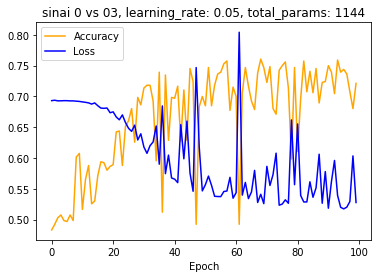

In [310]:
test_accuracies_toplot = np.array(test_accuracies) / 100.
plt.plot(test_accuracies_toplot, label='Accuracy', color='orange')
plt.plot(test_losses, label='Loss', color='blue')
plt.title('{}, learning_rate: {}, total_params: {}'.format(expName, lr, pytorch_total_params))
plt.xlabel('Epoch')
plt.legend()
plt.show()

   TARGET: tensor([ 1,  1,  0,  0,  0,  1,  0,  1,  0,  1])
PREDICTED: tensor([ 1,  0,  0,  0,  1,  1,  1,  1,  1,  1])


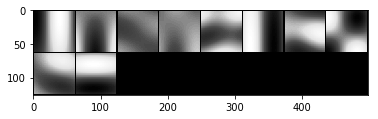

In [311]:
# Get some random testing images.
dataiter = iter(test_loader)
images_test, labels_test = dataiter.next()

inputs = Variable(images_test)
outputs = model(inputs)

pred = outputs.max(1, keepdim=True)[1]

print('   TARGET:', labels_test)
print('PREDICTED:', pred.view(-1))

# Print images.
imshow(torchvision.utils.make_grid(images_test))

In [312]:
test(model, test_loader, verbose=True)

Test set: Average loss: 0.5278, Accuracy: 476/660 (72%)


(0.5278072302991693, 72.12121212121212)

In [313]:
expN = 6

test_loader, train_loader = get_test_train_loaders(expN, batch_size, test_batch_size)
print(train_loader.dataset)
print(test_loader.dataset)
print()

expInfo, expName = exp_info(expN)
print(expInfo)

test(model, test_loader, verbose=True)

Dataset Billiard
    Number of datapoints: 1340
    Split: train
    Root Location: data/experiments/6
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset Billiard
    Number of datapoints: 660
    Split: test
    Root Location: data/experiments/6
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

Experiment #6
Dataset: sinai 0 vs 01
Portion of dataset for testing: 0.33
Splitting info:
{'chaotic': ['sinai01'], 'regular': ['sinai0']}
Labels mapping:
{'quarterL001': 0, 'rectangular': 1, 'sinai01': 2, 'sinai': 3, 'quarterL0': 4, 'circle_orange': 5, 'sinai03': 6, 'sinai02': 7, 'bunimovich': 8, 'sinai0': 9}
Splitting mapping:
{'chaotic': 0, 'regular': 1}

Test set: Average loss: 0.6261, Accuracy: 440/660 (67%)


(0.626090288884712, 66.66666666666667)

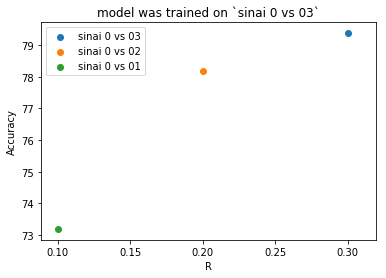

In [314]:
results = {
    'sinai 0 vs 03': {'R': 0.3, 'accuracy': 79.39},
    'sinai 0 vs 02': {'R': 0.2, 'accuracy': 78.18},
    'sinai 0 vs 01': {'R': 0.1, 'accuracy': 73.18}
}

for label in results:
    tmp_accuracy = results[label]['accuracy']
    tmp_R = results[label]['R']
    plt.scatter(tmp_R, tmp_accuracy, label=label)
plt.title('model was trained on `sinai 0 vs 03`')
plt.xlabel('R')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Research Only

In [19]:
raw_path = 'data/raw'
labels_mapping = utils.get_labels_mapping(utils.listdir(raw_path))

splitting_info = {
    'chaotic': ['cardioid07'],
    'regular': ['cardioid0']
}

config = {
    'test_size': 0.33,
    'labels_mapping': labels_mapping,
    'splitting_info': splitting_info,
    
    'piece_width': 120,
    'piece_height': 120,
    'num_pieces': 100,
    'downsampling_factor': 4
    
}

exper = Experiment(config=config, logging_level=logging.INFO)
print(exper)
exper.prepare_images()

DONE with Initialization. `expN` is 3 - INFO - experiment - 2018-07-16 19:03:17,175
Prepare images
======= - INFO - experiment - 2018-07-16 19:03:17,177


Experiment #3
--------------
Dataset: cardioid07 vs. cardioid0 

Portion of dataset for testing: 0.33
Splitting info:
{'chaotic': ['cardioid07'], 'regular': ['cardioid0']}

Labels mapping:
{'quarterL001': 0, 'test': 1, 'sinai01': 2, 'test1': 3, 'quarterL0': 4, 'circle_orange': 5, 'sinai03': 6, 'sinai02': 7, 'cardioid07': 8, 'cardioid0': 9, 'test2': 10, 'bunimovich': 11, 'sinai0': 12}
Splitting mapping:
{'chaotic': 0, 'regular': 1}


DONE with cardioid07 - INFO - experiment - 2018-07-16 19:03:17,885
DONE with cardioid0 - INFO - experiment - 2018-07-16 19:03:19,322


In [20]:
exper.slicing()
exper.dumping()
exper.split_test_train()

Slicing
======= - INFO - experiment - 2018-07-16 19:03:52,888
120 x 120 --> 30 x 30 - INFO - experiment - 2018-07-16 19:03:52,890
DONE with cardioid07 - INFO - experiment - 2018-07-16 19:03:56,250
DONE with cardioid0 - INFO - experiment - 2018-07-16 19:04:04,311
Dumping
======= - INFO - experiment - 2018-07-16 19:04:04,313
DONE with cardioid07 - INFO - experiment - 2018-07-16 19:04:04,927
DONE with cardioid0 - INFO - experiment - 2018-07-16 19:04:07,254
Split Test/Train
======= - INFO - experiment - 2018-07-16 19:04:07,256
Sizes: 2010 990 - INFO - experiment - 2018-07-16 19:04:07,327
DONE with train-images.pkl - INFO - experiment - 2018-07-16 19:04:07,395
DONE with test-images.pkl - INFO - experiment - 2018-07-16 19:04:07,411
DONE with train-labels.pkl - INFO - experiment - 2018-07-16 19:04:07,430
DONE with test-labels.pkl - INFO - experiment - 2018-07-16 19:04:07,448
DONE with train-energy-levels.pkl - INFO - experiment - 2018-07-16 19:04:07,456
DONE with test-energy-levels.pkl - INFO

In [21]:
import logging

%load_ext autoreload
%autoreload 2

import src.utils
from src.experiment import Experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import training_module

expN = 2

batch_size = 30
test_batch_size = 10
selected_energy_levels = np.arange(490, 500)

test_loader, train_loader = training_module.get_test_train_loaders(expN, batch_size, test_batch_size, selected_energy_levels)
print(train_loader.dataset)
print(test_loader.dataset)
print()

expInfo, expName = training_module.exp_info(expN)
print(expInfo)

Processing... - INFO - billiard - 2018-07-16 19:11:12,229
Done! - INFO - billiard - 2018-07-16 19:11:12,298
Processing... - INFO - billiard - 2018-07-16 19:11:12,313
Done! - INFO - billiard - 2018-07-16 19:11:12,358


Dataset Billiard
    Number of datapoints: 1332
    Split: train
    Root Location: data/experiments/2
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset Billiard
    Number of datapoints: 668
    Split: test
    Root Location: data/experiments/2
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

Experiment #2
--------------
Dataset: cardioid07 vs. cardioid0 

Portion of dataset for testing: 0.33
Splitting info:
{'chaotic': ['cardioid07'], 'regular': ['cardioid0']}

Labels mapping:
{'quarterL001': 0, 'test': 1, 'sinai01': 2, 'test1': 3, 'quarterL0': 4, 'circle_orange': 5, 'sinai03': 6, 'sinai02': 7, 'cardioid07': 8, 'cardioid0': 9, 'test2': 10, 'bunimovich': 11, 'sinai0': 12}
Splitting mapping:
{'chaotic': 0, 'regular': 1}


tensor([ 0,  1,  0,  0,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,
         1,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,
         1,  0])


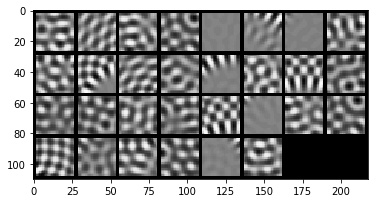

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy().astype('float32')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, energy_levels = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))
print(labels)

In [39]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import tqdm

model = training_module.Net(debug=False)

lr = 0.001
epochs = 100

optimizer = optim.Adam(model.parameters(), lr=lr)

test_losses = list()
test_accuracies = list()
pytorch_total_params = None
for epoch in tqdm.tqdm_notebook(range(1, epochs + 1)):
# for epoch in range(1, epochs + 1):
    training_module.train(model, train_loader, optimizer, epoch, -1)
    test_loss, accuracy = training_module.test(model, test_loader, verbose=True)
    
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    
    if epoch == 1:
        pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print('TOTAL PARAMETERS:', pytorch_total_params)

Test set: Average loss: 0.6930, Accuracy: 341/668 (51%)
TOTAL PARAMETERS: 450
Test set: Average loss: 0.6940, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6931, Accuracy: 341/668 (51%)
Test set: Average loss: 0.6934, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6938, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6936, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6937, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6933, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6935, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6931, Accuracy: 327/668 (49%)
Test set: Average loss: 0.6923, Accuracy: 375/668 (56%)
Test set: Average loss: 0.6911, Accuracy: 451/668 (68%)
Test set: Average loss: 0.6887, Accuracy: 397/668 (59%)
Test set: Average loss: 0.6857, Accuracy: 439/668 (66%)
Test set: Average loss: 0.6842, Accuracy: 401/668 (60%)
Test set: Average loss: 0.6818, Accuracy: 373/668 (56%)
Test set: Average loss: 0.6764, Accuracy: 436/668 (65%)
Test set: Average loss: 0.

TypeError: float() argument must be a string or a number, not 'Image'

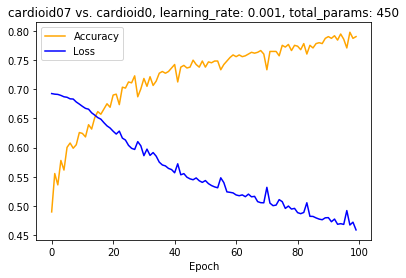

In [33]:
test_accuracies_toplot = np.array(test_accuracies) / 100.
plt.plot(test_accuracies_toplot, label='Accuracy', color='orange')
plt.plot(test_losses, label='Loss', color='blue')
plt.title('{}, learning_rate: {}, total_params: {}'.format(expName, lr, pytorch_total_params))
plt.xlabel('Epoch')
plt.legend()
plt.show()

   TARGET: tensor([ 1,  1,  1,  0,  0,  1,  1,  0,  1,  0])
PREDICTED: tensor([ 1,  1,  1,  0,  0,  1,  1,  0,  1,  1])


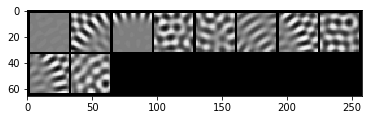

In [34]:
# Get some random testing images.
dataiter = iter(test_loader)
images_test, labels_test, _ = dataiter.next()

inputs = Variable(images_test)
outputs = model(inputs)

pred = outputs.max(1, keepdim=True)[1]

print('   TARGET:', labels_test)
print('PREDICTED:', pred.view(-1))

# Print images.
imshow(torchvision.utils.make_grid(images_test))